In [1]:
%matplotlib inline
%config InlineBackent.figure_format = 'retina'
import numpy as np
import torch
import helper as helper
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch import nn
import torch.nn.functional as F
from torch import optim

In [2]:
import torch
from torchvision import datasets, transforms
import helper

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5), (0.5)),])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

train_losses, test_losses = [], []


In [3]:
def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

plt.tight_layout()

<Figure size 432x288 with 0 Axes>

In [9]:
class Network(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, drop_p=0.15):
        ''' Builds a feedforward network with arbitrary hidden layers.
        
            Arguments
            ---------
            input_size: integer, size of the input layer
            output_size: integer, size of the output layer
            hidden_layers: list of integers, the sizes of the hidden layers
        
        '''
        super().__init__()
        # Input to a hidden layer
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        
        # Add a variable number of more hidden layers
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        
        self.output = nn.Linear(hidden_layers[-1], output_size)
        
        self.dropout = nn.Dropout(p=drop_p)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        
        for each in self.hidden_layers:
            x = F.relu(each(x))
            x = self.dropout(x)
        x = self.output(x)
        
        return F.log_softmax(x, dim=1)


def validation(model, testloader, criterion):
    accuracy = 0
    test_loss = 0
    for images, labels in testloader:

        images = images.resize_(images.size()[0], 784)

        output = model.forward(images)
        test_loss += criterion(output, labels).item()

        ## Calculating the accuracy 
        # Model's output is log-softmax, take exponential to get the probabilities
        ps = torch.exp(output)
        # Class with highest probability is our predicted class, compare with true label
        equality = (labels.data == ps.max(1)[1])
        # Accuracy is number of correct predictions divided by all predictions, just take the mean
        accuracy += equality.type_as(torch.FloatTensor()).mean()

    return test_loss, accuracy


def train(model, trainloader, testloader, criterion, optimizer, epochs=5, print_every=40):
    
    steps = 0
    running_loss = 0
    
    for e in range(epochs):
        running_loss_total = 0
        # Model in training mode, dropout is on
        model.train()
        for images, labels in trainloader:
            steps += 1
            
            # Flatten images into a 784 long vector
            images.resize_(images.size()[0], 784)
            
            optimizer.zero_grad()
            
            output = model.forward(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            running_loss_total += loss.item()


            if steps % print_every == 0:
                # Model in inference mode, dropout is off
                model.eval()
                
                # Turn off gradients for validation, will speed up inference
                with torch.no_grad():
                    test_loss, accuracy = validation(model, testloader, criterion)
                

        
                print("Epoch: {}/{}.. ".format(e+1, epochs),
                      "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                      "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
                      "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
                
                running_loss = 0
                
                # Make sure dropout and grads are on for training
                model.train()

                
        train_losses.append(running_loss_total/len(trainloader))
        test_losses.append(test_loss/len(testloader))
            

In [11]:
model = Network(784, 10, [512,256])
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.065)
train(model, trainloader, testloader, criterion, optimizer, epochs=30)

Epoch: 1/30..  Training Loss: 1.669..  Test Loss: 1.125..  Test Accuracy: 0.573
Epoch: 1/30..  Training Loss: 0.907..  Test Loss: 0.788..  Test Accuracy: 0.714
Epoch: 1/30..  Training Loss: 0.742..  Test Loss: 0.718..  Test Accuracy: 0.735
Epoch: 1/30..  Training Loss: 0.699..  Test Loss: 0.720..  Test Accuracy: 0.723
Epoch: 1/30..  Training Loss: 0.660..  Test Loss: 0.616..  Test Accuracy: 0.770
Epoch: 1/30..  Training Loss: 0.613..  Test Loss: 0.575..  Test Accuracy: 0.787
Epoch: 1/30..  Training Loss: 0.582..  Test Loss: 0.558..  Test Accuracy: 0.790
Epoch: 1/30..  Training Loss: 0.574..  Test Loss: 0.547..  Test Accuracy: 0.802
Epoch: 1/30..  Training Loss: 0.587..  Test Loss: 0.558..  Test Accuracy: 0.795
Epoch: 1/30..  Training Loss: 0.545..  Test Loss: 0.515..  Test Accuracy: 0.811
Epoch: 1/30..  Training Loss: 0.525..  Test Loss: 0.516..  Test Accuracy: 0.812
Epoch: 1/30..  Training Loss: 0.533..  Test Loss: 0.516..  Test Accuracy: 0.810
Epoch: 1/30..  Training Loss: 0.517..  T

Epoch: 5/30..  Training Loss: 0.352..  Test Loss: 0.363..  Test Accuracy: 0.869
Epoch: 5/30..  Training Loss: 0.326..  Test Loss: 0.368..  Test Accuracy: 0.867
Epoch: 5/30..  Training Loss: 0.335..  Test Loss: 0.364..  Test Accuracy: 0.868
Epoch: 5/30..  Training Loss: 0.335..  Test Loss: 0.377..  Test Accuracy: 0.861
Epoch: 5/30..  Training Loss: 0.345..  Test Loss: 0.357..  Test Accuracy: 0.868
Epoch: 5/30..  Training Loss: 0.357..  Test Loss: 0.375..  Test Accuracy: 0.862
Epoch: 5/30..  Training Loss: 0.317..  Test Loss: 0.348..  Test Accuracy: 0.872
Epoch: 5/30..  Training Loss: 0.339..  Test Loss: 0.366..  Test Accuracy: 0.865
Epoch: 5/30..  Training Loss: 0.321..  Test Loss: 0.386..  Test Accuracy: 0.863
Epoch: 5/30..  Training Loss: 0.335..  Test Loss: 0.362..  Test Accuracy: 0.869
Epoch: 5/30..  Training Loss: 0.324..  Test Loss: 0.355..  Test Accuracy: 0.873
Epoch: 5/30..  Training Loss: 0.307..  Test Loss: 0.358..  Test Accuracy: 0.869
Epoch: 5/30..  Training Loss: 0.328..  T

Epoch: 9/30..  Training Loss: 0.271..  Test Loss: 0.325..  Test Accuracy: 0.881
Epoch: 9/30..  Training Loss: 0.274..  Test Loss: 0.342..  Test Accuracy: 0.878
Epoch: 9/30..  Training Loss: 0.256..  Test Loss: 0.334..  Test Accuracy: 0.878
Epoch: 9/30..  Training Loss: 0.301..  Test Loss: 0.326..  Test Accuracy: 0.882
Epoch: 9/30..  Training Loss: 0.283..  Test Loss: 0.337..  Test Accuracy: 0.877
Epoch: 10/30..  Training Loss: 0.262..  Test Loss: 0.329..  Test Accuracy: 0.879
Epoch: 10/30..  Training Loss: 0.268..  Test Loss: 0.342..  Test Accuracy: 0.875
Epoch: 10/30..  Training Loss: 0.253..  Test Loss: 0.353..  Test Accuracy: 0.875
Epoch: 10/30..  Training Loss: 0.267..  Test Loss: 0.332..  Test Accuracy: 0.879
Epoch: 10/30..  Training Loss: 0.287..  Test Loss: 0.336..  Test Accuracy: 0.879
Epoch: 10/30..  Training Loss: 0.275..  Test Loss: 0.330..  Test Accuracy: 0.882
Epoch: 10/30..  Training Loss: 0.283..  Test Loss: 0.332..  Test Accuracy: 0.878
Epoch: 10/30..  Training Loss: 0.

Epoch: 14/30..  Training Loss: 0.248..  Test Loss: 0.327..  Test Accuracy: 0.886
Epoch: 14/30..  Training Loss: 0.220..  Test Loss: 0.319..  Test Accuracy: 0.885
Epoch: 14/30..  Training Loss: 0.251..  Test Loss: 0.319..  Test Accuracy: 0.884
Epoch: 14/30..  Training Loss: 0.232..  Test Loss: 0.318..  Test Accuracy: 0.887
Epoch: 14/30..  Training Loss: 0.234..  Test Loss: 0.323..  Test Accuracy: 0.882
Epoch: 14/30..  Training Loss: 0.259..  Test Loss: 0.315..  Test Accuracy: 0.891
Epoch: 14/30..  Training Loss: 0.250..  Test Loss: 0.321..  Test Accuracy: 0.886
Epoch: 14/30..  Training Loss: 0.216..  Test Loss: 0.318..  Test Accuracy: 0.884
Epoch: 14/30..  Training Loss: 0.261..  Test Loss: 0.312..  Test Accuracy: 0.886
Epoch: 14/30..  Training Loss: 0.227..  Test Loss: 0.329..  Test Accuracy: 0.882
Epoch: 14/30..  Training Loss: 0.215..  Test Loss: 0.324..  Test Accuracy: 0.887
Epoch: 14/30..  Training Loss: 0.247..  Test Loss: 0.314..  Test Accuracy: 0.889
Epoch: 14/30..  Training Los

Epoch: 18/30..  Training Loss: 0.211..  Test Loss: 0.316..  Test Accuracy: 0.891
Epoch: 18/30..  Training Loss: 0.234..  Test Loss: 0.314..  Test Accuracy: 0.889
Epoch: 18/30..  Training Loss: 0.231..  Test Loss: 0.305..  Test Accuracy: 0.890
Epoch: 18/30..  Training Loss: 0.204..  Test Loss: 0.312..  Test Accuracy: 0.889
Epoch: 18/30..  Training Loss: 0.228..  Test Loss: 0.313..  Test Accuracy: 0.886
Epoch: 18/30..  Training Loss: 0.215..  Test Loss: 0.314..  Test Accuracy: 0.889
Epoch: 18/30..  Training Loss: 0.187..  Test Loss: 0.325..  Test Accuracy: 0.890
Epoch: 18/30..  Training Loss: 0.221..  Test Loss: 0.317..  Test Accuracy: 0.892
Epoch: 18/30..  Training Loss: 0.203..  Test Loss: 0.320..  Test Accuracy: 0.889
Epoch: 18/30..  Training Loss: 0.200..  Test Loss: 0.329..  Test Accuracy: 0.884
Epoch: 18/30..  Training Loss: 0.208..  Test Loss: 0.331..  Test Accuracy: 0.888
Epoch: 18/30..  Training Loss: 0.222..  Test Loss: 0.313..  Test Accuracy: 0.890
Epoch: 19/30..  Training Los

Epoch: 22/30..  Training Loss: 0.187..  Test Loss: 0.311..  Test Accuracy: 0.895
Epoch: 22/30..  Training Loss: 0.191..  Test Loss: 0.315..  Test Accuracy: 0.891
Epoch: 22/30..  Training Loss: 0.213..  Test Loss: 0.326..  Test Accuracy: 0.885
Epoch: 23/30..  Training Loss: 0.193..  Test Loss: 0.313..  Test Accuracy: 0.895
Epoch: 23/30..  Training Loss: 0.176..  Test Loss: 0.330..  Test Accuracy: 0.888
Epoch: 23/30..  Training Loss: 0.179..  Test Loss: 0.305..  Test Accuracy: 0.895
Epoch: 23/30..  Training Loss: 0.168..  Test Loss: 0.315..  Test Accuracy: 0.895
Epoch: 23/30..  Training Loss: 0.185..  Test Loss: 0.305..  Test Accuracy: 0.895
Epoch: 23/30..  Training Loss: 0.168..  Test Loss: 0.329..  Test Accuracy: 0.889
Epoch: 23/30..  Training Loss: 0.186..  Test Loss: 0.319..  Test Accuracy: 0.894
Epoch: 23/30..  Training Loss: 0.184..  Test Loss: 0.325..  Test Accuracy: 0.887
Epoch: 23/30..  Training Loss: 0.189..  Test Loss: 0.313..  Test Accuracy: 0.891
Epoch: 23/30..  Training Los

Epoch: 27/30..  Training Loss: 0.160..  Test Loss: 0.318..  Test Accuracy: 0.891
Epoch: 27/30..  Training Loss: 0.172..  Test Loss: 0.312..  Test Accuracy: 0.895
Epoch: 27/30..  Training Loss: 0.184..  Test Loss: 0.320..  Test Accuracy: 0.896
Epoch: 27/30..  Training Loss: 0.159..  Test Loss: 0.346..  Test Accuracy: 0.888
Epoch: 27/30..  Training Loss: 0.161..  Test Loss: 0.320..  Test Accuracy: 0.896
Epoch: 27/30..  Training Loss: 0.158..  Test Loss: 0.317..  Test Accuracy: 0.892
Epoch: 27/30..  Training Loss: 0.183..  Test Loss: 0.317..  Test Accuracy: 0.894
Epoch: 27/30..  Training Loss: 0.169..  Test Loss: 0.330..  Test Accuracy: 0.890
Epoch: 27/30..  Training Loss: 0.164..  Test Loss: 0.323..  Test Accuracy: 0.892
Epoch: 27/30..  Training Loss: 0.178..  Test Loss: 0.317..  Test Accuracy: 0.893
Epoch: 27/30..  Training Loss: 0.194..  Test Loss: 0.319..  Test Accuracy: 0.891
Epoch: 27/30..  Training Loss: 0.144..  Test Loss: 0.338..  Test Accuracy: 0.890
Epoch: 27/30..  Training Los

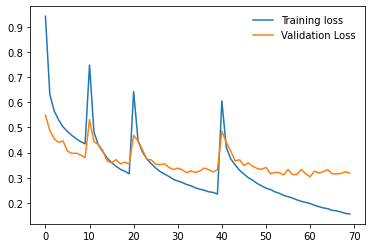

In [12]:
plt.plot(train_losses, label = 'Training loss')
plt.plot(test_losses, label ='Validation Loss')
plt.legend(frameon=False)

In [13]:
print("Our model: \n\n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())

Our model: 

 Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
  )
  (output): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.15, inplace=False)
) 

The state dict keys: 

 odict_keys(['hidden_layers.0.weight', 'hidden_layers.0.bias', 'hidden_layers.1.weight', 'hidden_layers.1.bias', 'output.weight', 'output.bias'])


In [14]:
checkpoint = {'input_size': 784,
              'output_size': 10,
              'hidden_layers': [each.out_features for each in model.hidden_layers],
              'state_dict': model.state_dict()}

torch.save(checkpoint, 'checkpoint.pth')

In [15]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = Network(checkpoint['input_size'],
                    checkpoint['output_size'],
                    checkpoint['hidden_layers'])
    model.load_state_dict(checkpoint['state_dict'])
    
    return model

In [16]:
model = load_checkpoint('checkpoint.pth')
print(model)

Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
  )
  (output): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.15, inplace=False)
)


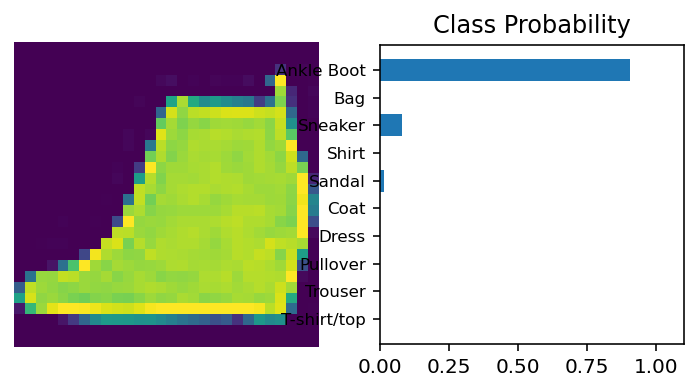

In [17]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper

# Test out your network!

dataiter = iter(testloader)
images, labels = dataiter.next()

model.eval()
images.resize_(images.size()[0], 784)
output = model.forward(images)

# TODO: Calculate the class probabilities (softmax) for img

img = images[3]
ps = torch.exp(output[3])

# Plot the image and probabilities
view_classify(img, ps, version='Fashion')